In [91]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np

[*********************100%***********************]  1 of 1 completed


=== RISK: 0.01 | REWARD: 0.04 METRICS ===
Total Trades: 260
Wins: 51
Losses: 209
Win Rate: 19.62%
Average Return per Trade: -0.0002
Risk/Reward Ratio: 4.0
Average Trade Length (bars): 8.53
Longest Trade (bars): 46
Shortest Trade (bars): 1


[0.99,
 0.9801,
 1.019304,
 1.00911096,
 0.9990198503999999,
 0.9890296518959999,
 1.02859083797184,
 1.0183049295921216,
 1.0081218802962004,
 0.9980406614932384,
 0.9880602548783061,
 0.978179652329523,
 0.9683978558062277,
 0.9587138772481655,
 0.9491267384756839,
 0.939635471090927,
 0.9302391163800178,
 0.9674486810352185,
 0.9577741942248663,
 0.9481964522826176,
 0.9387144877597914,
 0.9293273428821934,
 0.9200340694533715,
 0.9108337287588378,
 0.9017253914712494,
 0.8927081375565369,
 0.8837810561809715,
 0.8749432456191617,
 0.8661938131629701,
 0.9008415656894889,
 0.9368752283170685,
 0.9275064760338978,
 0.9182314112735588,
 0.9090490971608232,
 0.899958606189215,
 0.8909590201273229,
 0.8820494299260496,
 0.8732289356267892,
 0.9081580930518608,
 0.8990765121213422,
 0.8900857470001288,
 0.8811848895301275,
 0.8723730406348262,
 0.863649310228478,
 0.8981952826376172,
 0.9341230939431219,
 0.9247818630036907,
 0.9155340443736538,
 0.9521554061486001,
 0.942633852087114,
 

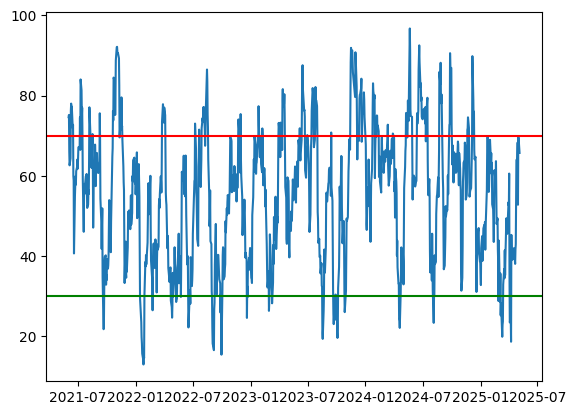

In [ ]:
TICKER = 'SPY'
RSI_LENGTH = 14
OVERBOUGHT = 70
OVERSOLD = 30
RISK = .01
REWARD = .04
LOOKBACK = 1000

def get_data(ticker=TICKER):
    df = yf.download(ticker)
    df.columns = df.columns.get_level_values(0)

    # only return the subset of data you are interested in
    return df.iloc[-LOOKBACK:, :]

def add_RSI(df, length=RSI_LENGTH):

    price_change = df['Close'].diff()
    
    # separate gains/losses
    gain = price_change.where(price_change > 0, 0)
    loss = -price_change.where(price_change < 0, 0)

    # average gain vs loss
    avg_gain = gain.rolling(window=length).mean()
    avg_loss = loss.rolling(window=length).mean()

    # calculate rsi
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    df['RSI'] = rsi

    # plot the relative strength index
    plt.plot(df['RSI'])
    plt.axhline(OVERBOUGHT, color='red')
    plt.axhline(OVERSOLD, color='green')

    return df.dropna()

def add_strategy(df, overbought=OVERBOUGHT, oversold=OVERSOLD):

    df['Strategy'] = 0
    df['Strategy'] = np.where(df['RSI'] > overbought, -1, 
                     np.where(df['RSI'] < oversold, 1, 0))
    
    # shift back to make sure we have seen the signal
    df['Strategy'] = df['Strategy'].shift(1)
    return df

def set_risk_reward_strat(df, risk=RISK, reward=REWARD):

    wins = []
    losses = []
    lengths = []

    # looping through rows
    for i in range(len(df)):
        signal = df['Strategy'].iloc[i]
        entry_price = df['Close'].iloc[i]

        # targets depend on signal
        if signal == 1:
            target = entry_price * (1 + REWARD)
            stop = entry_price * (1 - RISK)
        elif signal == -1:
            target = entry_price * (1 - REWARD)
            stop = entry_price * (1 + RISK)
        else:
            continue
        
        trade_len = 0
        for price in df['Close'].iloc[i + 1:]:

            # add a bar for every day after trade is opened
            trade_len += 1

            # for wins
            if signal == 1:
                if price >= target:
                    wins.append(reward)
                    lengths.append(trade_len)
                    break
                if price <= stop:
                    losses.append(-risk)
                    lengths.append(trade_len)
                    break

            # for losses
            if signal == -1:
                if price <= target:
                    wins.append(reward)
                    lengths.append(trade_len)
                    break
                if price >= stop:
                    losses.append(-risk)
                    lengths.append(trade_len)
                    break

    total_trades = len(wins) + len(losses)
    win_rate = len(wins) / total_trades * 100 if total_trades > 0 else 0

    avg_win = sum(wins) / len(wins) if wins else 0
    avg_loss = sum(losses) / len(losses) if losses else 0
    avg_return = (sum(wins) + sum(losses)) / total_trades if total_trades > 0 else 0

    avg_length = sum(lengths) / len(lengths) if lengths else 0
    max_length = max(lengths) if lengths else 0
    min_length = min(lengths) if lengths else 0

    risk_reward_ratio = avg_win / abs(avg_loss) if avg_loss != 0 else float('inf')

    print(f'\n=== RISK: {risk} | REWARD: {reward} METRICS ===')
    print(f'Total Trades: {total_trades}')
    print(f'Wins: {len(wins)}')
    print(f'Losses: {len(losses)}')
    print(f'Win Rate: {round(win_rate, 2)}%')
    print(f'Average Return per Trade: {round(avg_return, 4)}')
    print(f'Risk/Reward Ratio: {round(risk_reward_ratio, 2)}')
    print(f'Average Trade Length (bars): {round(avg_length, 2)}')
    print(f'Longest Trade (bars): {max_length}')
    print(f'Shortest Trade (bars): {min_length}')

    return

def main():
    df = get_data()
    df = add_RSI(df)
    df = add_strategy(df)
    win_rate = set_risk_reward_strat(df)

    return df

df = main()

def run_trade_simulation(df, trades=TRADE_COUNT, win_rate=WIN_RATE, risk=RISK, reward=REWARD):

    capital = 1
    capital_history = []

    for trade in range(trades):
        outcome = np.random.rand() * 100

        if outcome < win_rate:
            capital *= (1 + reward)

        else:
            capital *= (1 - risk)

        capital_history.append(capital)
    
    return capital_history

run_trade_simulation(df)